In [ ]:
# 1. Import Required Libraries
import re
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os
import subprocess

import pandas as pd
import matplotlib.pyplot as plt

# Event Age Timeline Analysis

This notebook scrapes a log file for event messages, extracts sender and age information, and plots event age per sender over time.

In [ ]:
log_file_path = '/tmp/sonic.log'

# Set SONIC_VERBOSITY=3 for the test execution
env = os.environ.copy()
env['SONIC_VERBOSITY'] = '3'

with open(log_file_path, 'w') as f:
    process = subprocess.run(['go', 'test', '.', '-v'], stdout=f, env=env)

In [ ]:
stake_values = []
with open(log_file_path, 'r') as f:
    for line in f:
        if line.startswith("stake:"):
            stake_values = [int(x) for x in re.findall(r'\d+', line)]

with_id = enumerate(stake_values)
# sort by stake value
sorted_stake = list(reversed(sorted(with_id, key=lambda x: x[1])))

total_stake = 0
for idx, stake in sorted_stake:
    total_stake += stake

stake_value = []
accumulated_stake = 0
for idx, stake in sorted_stake:
    accumulated_stake += stake
    if accumulated_stake > total_stake * 0.75:
        stake_value.append({'ID': idx, 'Suppressed': stake  })
    else:
        stake_value.append({'ID': idx, 'Dominant': stake     })
    
threshold = total_stake * 0.75

stake_df = pd.DataFrame(stake_value)

In [ ]:
def parseDate(time_str):
    dt = datetime.strptime(time_str, "%H:%M:%S.%f")
    seconds = dt.hour * 3600 + dt.minute * 60 + dt.second + dt.microsecond / 1e6
    return seconds

print(parseDate("14:11:13.788"))  # Example usage

def to_milliseconds(val):
    if 'ms' in val:
        return float(val.replace('ms', '')) 
    elif 'µs' in val:
        return float(val.replace('µs', '')) / 1000
    if 's' in val:
        return float(val.replace('s', '')) * 1000
    return float(val) / 1000

print(to_milliseconds("150ms"))  # Example usage
print(to_milliseconds("150µs"))  # Example usage
print(to_milliseconds("1.5"))  # Example usage
print(to_milliseconds("1.5s"))  # Example usage

51073.788
150.0
0.15
0.0015
1500.0


In [ ]:
# Updated regex to support age and t with or without quotes and with ms or µs units
justEventEmitted = re.compile(r'New event emitted')
pattern = re.compile(r'INFO\s+\[(\d+-\d+)\|(\d+:\d+:\d+\.\d+)\]\s+New event emitted\s+id=(\d+:\d+:[0-9a-f]+)\s+parents=(\d+)\s+by=(\d+)\s+frame=(\d+)\s+txs=(\d+)\s+age=(?:"?)([\d\.]+(?:ms|µs))(?:"?)\s+t=(?:"?)([\d\.]+(?:ms|µs))(?:"?)')

rows = []
count = 0
with open(log_file_path, 'r') as f:
    for line in f:
        isEventEmitted = justEventEmitted.search(line)
        if isEventEmitted:
            count += 1

        match = pattern.search(line)
        if match:
            _, date, id, parents, by, frame, txs, age, t = match.groups()
            rows.append({
                'id': id,
                'timestamp': parseDate(date),
                'parents': int(parents),
                'by': int(by),
                'frame': int(frame),
                'txs': int(txs),
                'age': age,
                't': t
            })
        else:
            if isEventEmitted:
                print(f"Warning: Line matched 'New event emitted' but did not match full pattern:\n{line}")

# sanity check, are there count rows? 
if len(rows) != count:
    print(f"Warning: Expected {count} rows, but found {len(rows)} rows.")

# Convert to DataFrame and Group by Sender
df = pd.DataFrame(rows)
groups = df.groupby('by')

In [ ]:
# Compile regex to match "Emitting is paused" log lines with timestamp
paused_pattern = re.compile(r'INFO\s+\[(\d+-\d+)\|(\d+:\d+:\d+\.\d+)\].*Emitting is paused')

paused_rows = []
with open(log_file_path, 'r') as f:
    for line in f:
        match = paused_pattern.search(line)
        if match:
            _, date = match.groups()
            paused_rows.append({
                'timestamp': parseDate(date),
                'paused': 1
            })

paused_df = pd.DataFrame(paused_rows)
# print(paused_df.head())

In [ ]:
# Compile regex to match "Got shutdown signal" log lines with timestamp
shutdown_pattern = re.compile(r'INFO\s+\[(\d+-\d+)\|(\d+:\d+:\d+\.\d+)\].*Got shutdown signal')

shutdown_rows = []
with open(log_file_path, 'r') as f:
    for line in f:
        match = shutdown_pattern.search(line)
        if match:
            _, date = match.groups()
            shutdown_rows.append({
                'timestamp': parseDate(date),
                'shutdown': 1
            })

shutdown_df = pd.DataFrame(shutdown_rows)
# print(shutdown_df.head())

In [ ]:
# Compile regex to match "New block" log lines with relevant fields
block_pattern = re.compile(
    r'INFO\s+\[(\d+-\d+)\|(\d+:\d+:\d+\.\d+)\]\s+New block\s+index=(\d+)\s+id=([0-9a-f\.]+)\s+gas_used=([\d,]+)\s+gas_rate=([\d\.]+)\s+base_fee=(\d+)\s+txs=(\d+)/(\d+)\s+age="?(\d+(?:\.\d+)(?:ms|µs|s)?)"?\s+t="?(\d+(?:\.\d+)(?:ms|µs|s)?)"?\s+epoch=(\d+)'
)


block_rows = []
block_count = 0
with open(log_file_path, 'r') as f:
    for line in f:
        if 'New block' in line:
            block_count += 1
        match = block_pattern.search(line)
        if match:
            # print(f"Matched 'New block' line: {line.strip()}")
            _, date, index, block_id, gas_used, gas_rate, base_fee, txs, skipped, age, t, epoch= match.groups()
            block_rows.append({
                'timestamp': parseDate(date),
                'index': int(index),
                'id': block_id,
                'gas_used': int(gas_used.replace(',', '')),
                'gas_rate': float(gas_rate),
                'base_fee': int(base_fee),
                'txs': int(txs),
                'skipped': int(skipped),
                'age': age,
                't': t,
                'epoch': int(epoch)
            })
        else:
            if 'New block' in line:
                print(f"Warning: Line matched 'New block' but did not match full pattern:\n{line}")

# Sanity check: number of 'New block' lines vs. DataFrame rows
if len(block_rows) != block_count:
    print(f"Warning: Expected {block_count} block rows, but found {len(block_rows)} rows in DataFrame.")

block_df = pd.DataFrame(block_rows)
blocks = block_df.groupby('index')


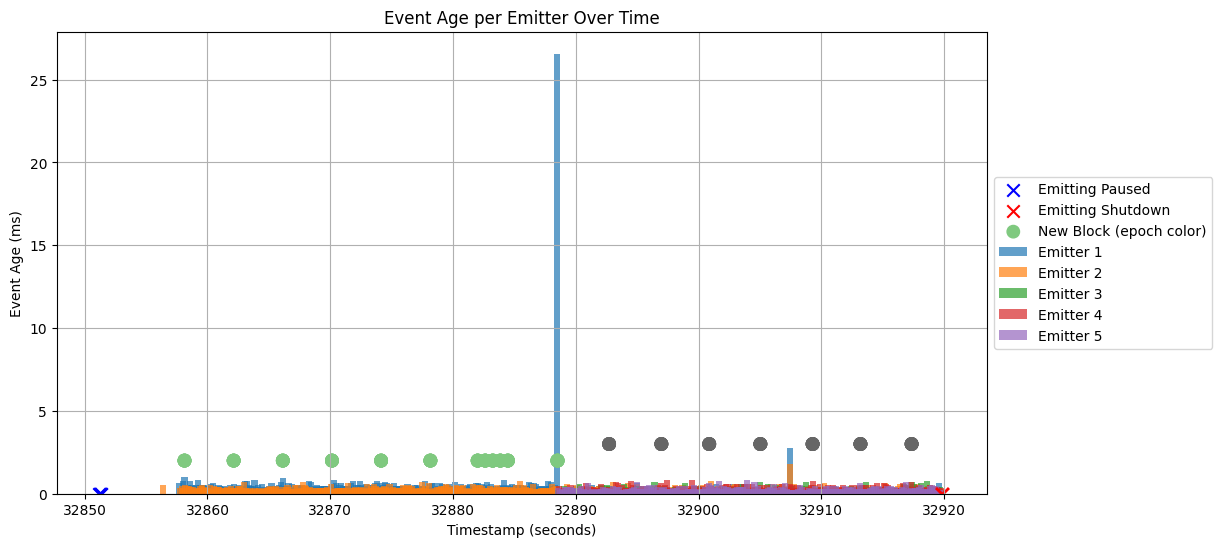

In [ ]:
plt.figure(figsize=(12, 6))
for emitter, group in groups:
    # Convert age to microseconds
    ages_us = group['age'].apply(to_milliseconds)
    plt.bar(group['timestamp'], ages_us, width=0.5, label=f'Emitter {emitter}', alpha=0.7)

# Overlay paused_df markers
if not paused_df.empty:
    plt.scatter(paused_df['timestamp'], [0]*len(paused_df), color='blue', marker='x', s=80, label='Emitting Paused')

# Overlay shutdown_df markers
if not shutdown_df.empty:
    plt.scatter(shutdown_df['timestamp'], [0]*len(shutdown_df), color='red', marker='x', s=80, label='Emitting Shutdown')

if not block_df.empty:
    # Normalize epoch values for colormap
    epochs = block_df['epoch']
    norm = plt.Normalize(epochs.min(), epochs.max())
    cmap = plt.get_cmap('Accent')
    colors = cmap(norm(epochs))
    plt.scatter(block_df['timestamp'], block_df['epoch'], color=colors, marker='o', s=80, label='New Block (epoch color)')

plt.xlabel('Timestamp (seconds)')
plt.ylabel('Event Age (ms)')
plt.title('Event Age per Emitter Over Time')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

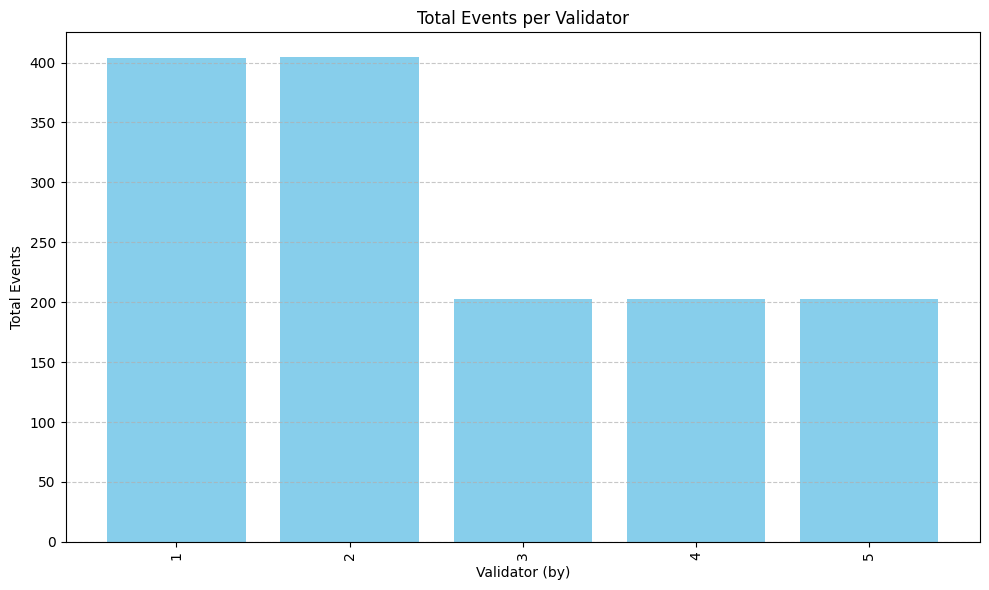

In [ ]:
plt.figure(figsize=(10, 6))
event_counts = df['by'].value_counts().sort_index()
plt.bar(event_counts.index.astype(str), event_counts.values, color='skyblue')
plt.xlabel('Validator (by)')
plt.ylabel('Total Events')
plt.title('Total Events per Validator')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

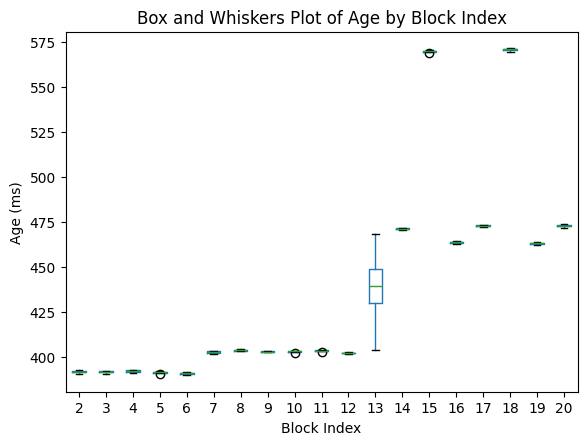

In [ ]:
block_df['age_ms'] = block_df['age'].apply(to_milliseconds)

plt.figure(figsize=(12, 6))
block_df.boxplot(column='age_ms', by='index', grid=False)
plt.xlabel('Block Index')
plt.ylabel('Age (ms)')
plt.title('Box and Whiskers Plot of Age by Block Index')
plt.suptitle('')
plt.show()

In [ ]:
validator_pattern = re.compile(
    r'INFO\s+\[(\d+-\d+)\|(\d+:\d+:\d+\.\d+)\]\s+Validator state\s+i=(\d+)\s+id=(\d+)\s+uptime=(\d+)\s+lastBlock=(\d+)\s+lastOnlineTime=(\d+)'
)

validator_states = []
with open(log_file_path, 'r') as f:
    for line in f:
        match = validator_pattern.search(line)
        if match:
            _, date,i,  validator_id, uptime, last_block, last_online_time = match.groups()
            validator_states.append({
                'timestamp': parseDate(date),
                "i": int(i),
                'validator_id': int(validator_id),
                'uptime': int(uptime),
                'last_block': int(last_block),
                'last_online_time': int(last_online_time)
            })


# make dataset available for analysis
df_validator_states = pd.DataFrame(validator_states)

In [ ]:
if len(df_validator_states) > 0:
    plt.figure(figsize=(12, 6))
    df_validator_states.boxplot(column='uptime', by='validator_id', grid=False)
    plt.ylabel('Validator ID')
    plt.xlabel('Uptime')
    plt.title('Box and Whiskers Plot of Uptime per Validator')
    plt.suptitle('')
    plt.show()
else:
    print("No validator state data found.")

No validator state data found.
